# GO enrichment analysis

- [Workflow that I follow here](https://www.melbournebioinformatics.org.au/tutorials/tutorials/seurat-go/seurat-go/)

In [1]:
# load libraries
suppressPackageStartupMessages({
  library(Seurat)
  library(Signac)
  library(EnsDb.Hsapiens.v86)
  library(ggplot2)
  library(cowplot)
  library(clusterProfiler)
  library(org.Hs.eg.db)
  library(enrichplot)
})

In [ ]:
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_subset_stripped.h5ad"
output_csv = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/PDS_classifier.csv"
clusters_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/clusters_scmiko_subset_chosen_res.csv"

In [3]:
suppressPackageStartupMessages({library(Seurat)})
srt = schard::h5ad2seurat(input_file)
srt[['RNA']]$data = as.matrix(schard::h5ad2Matrix(input_file, name = "/layers/log1p_norm_of_counts"))
stopifnot(!(all(srt[['RNA']]$data[1:50]%%1 == 0))) # check values (not integer)
names(srt@reductions) = c('diffmap', 'pca', 'tsne', 'umap')

srt

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


An object of class Seurat 
11449 features across 22799 samples within 1 assay 
Active assay: RNA (11449 features, 0 variable features)
 2 layers present: counts, data
 4 dimensional reductions calculated: diffmap, pca, tsne, umap

In [4]:
clusters = read.csv(clusters_file) |> dplyr::rename(cluster = !!2) |> tibble::column_to_rownames("X")
stopifnot(all(rownames(srt@meta.data) == rownames(clusters))) # check if same cells
srt$clusters = clusters

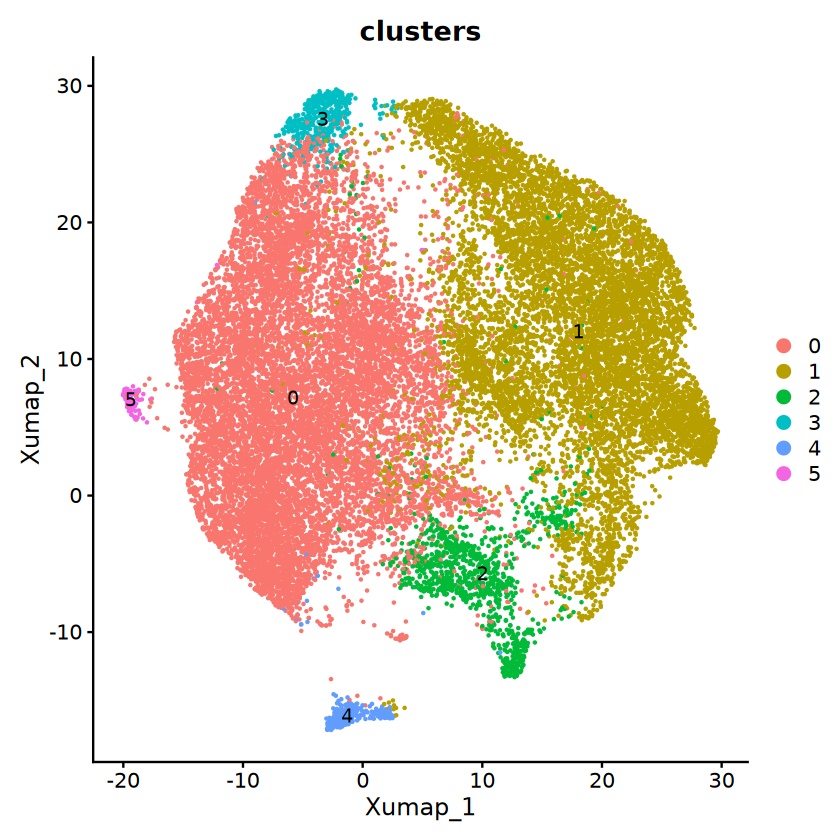

In [7]:
DimPlot(srt, group.by = "clusters", label = TRUE)

>### Find marker genes for each cell sub-type
>We aim to find marker genes for each cluster to further explore the differences.

In [5]:
Idents(srt) <- "clusters"
marker.genes <- FindAllMarkers(srt, only.pos = TRUE, 
                                        min.pct = 0.5, logfc.threshold = 0.5)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 3

Calculating cluster 5

Calculating cluster 2

Calculating cluster 4



>### Gene Ontology analysis
>We now have a marker gene list for each cluster. But it can be difficult to interpret a cluster based on gene names alone. A good method to interpret a list of genes is gene ontology analysis. We will perform gene ontology analysis to understand the biological functions of these marker genes.
>
>#### Preview the marker genes
>Let’s have a look the data structure of the marker gene list.

In [6]:
marker.genes[1:5, ]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
HELLS,0,2.001524,0.584,0.233,0,0,HELLS
MT-ND2,0,1.979278,0.753,0.413,0,0,MT-ND2
PHGDH,0,1.092850,0.741,0.404,0,0,PHGDH
CDT1,0,1.705506,0.508,0.171,0,0,CDT1
MT-ND5,0,1.779028,0.762,0.432,0,0,MT-ND5


## Perform gene ontology analysis for all clusters

In [28]:
cluster_gene_list <- split(marker.genes$gene, marker.genes$cluster)

cluster_gene_list <- lapply(cluster_gene_list, function(genes) {
  gene_ids <- bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)
  return(gene_ids$ENTREZID)
})

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"9.77% of input gene IDs are fail to map..."
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"1.27% of input gene IDs are fail to map..."
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"2.03% of input gene IDs are fail to map..."
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"0.92% of input gene IDs are fail to map..."
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"0.43% of input gene IDs are fail to map..."
'sele

### Biological process (BP) ontology

In [29]:
# GO enrichment analysis for BP
go_compare_bp <- compareCluster(geneCluster = cluster_gene_list, 
                             fun = "enrichGO", 
                             OrgDb = org.Hs.eg.db, 
                             ont = "BP",  # "BP"、"MF" or "CC"
                             pAdjustMethod = "BH",
                             pvalueCutoff = 0.05,
                             qvalueCutoff = 0.05)

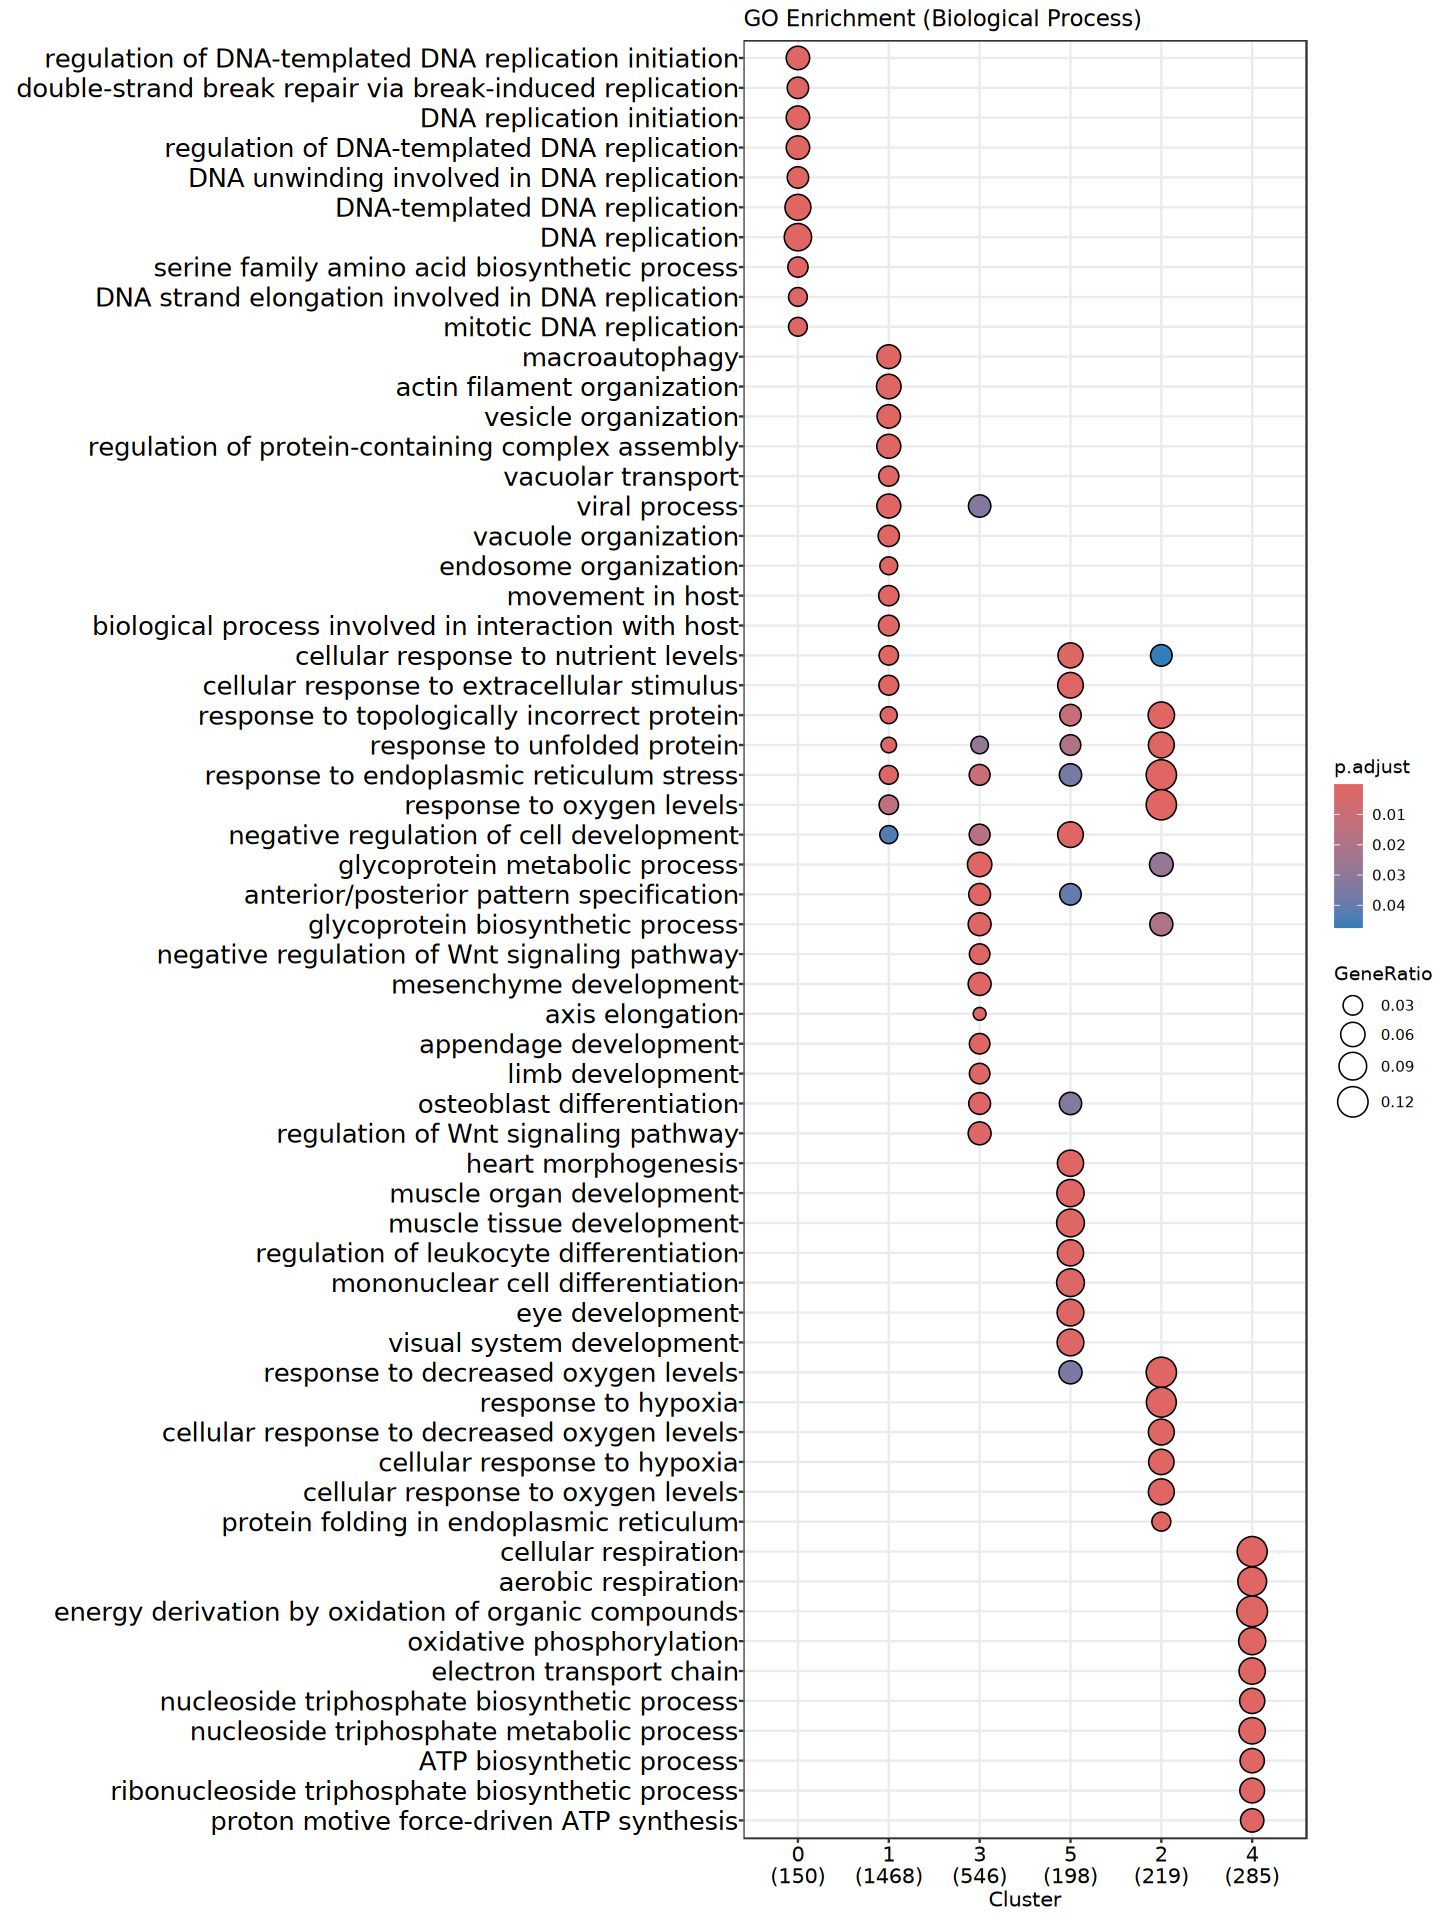

In [67]:
options(repr.plot.width = 12, repr.plot.height = 16)
cluster.p1 <- dotplot(go_compare_bp, showCategory = 10, label_format = 100,
              title = "GO Enrichment (Biological Process)")
cluster.p1 + theme(axis.text.y = element_text(size = 15)) +
    # increase y label space
    theme(axis.text.y = element_text(margin = margin(0, 0, 0, 60)))

Warning message in (function (..., type = getOption("ggplot2.continuous.fill")) :
"log-10 transformation introduced infinite values."


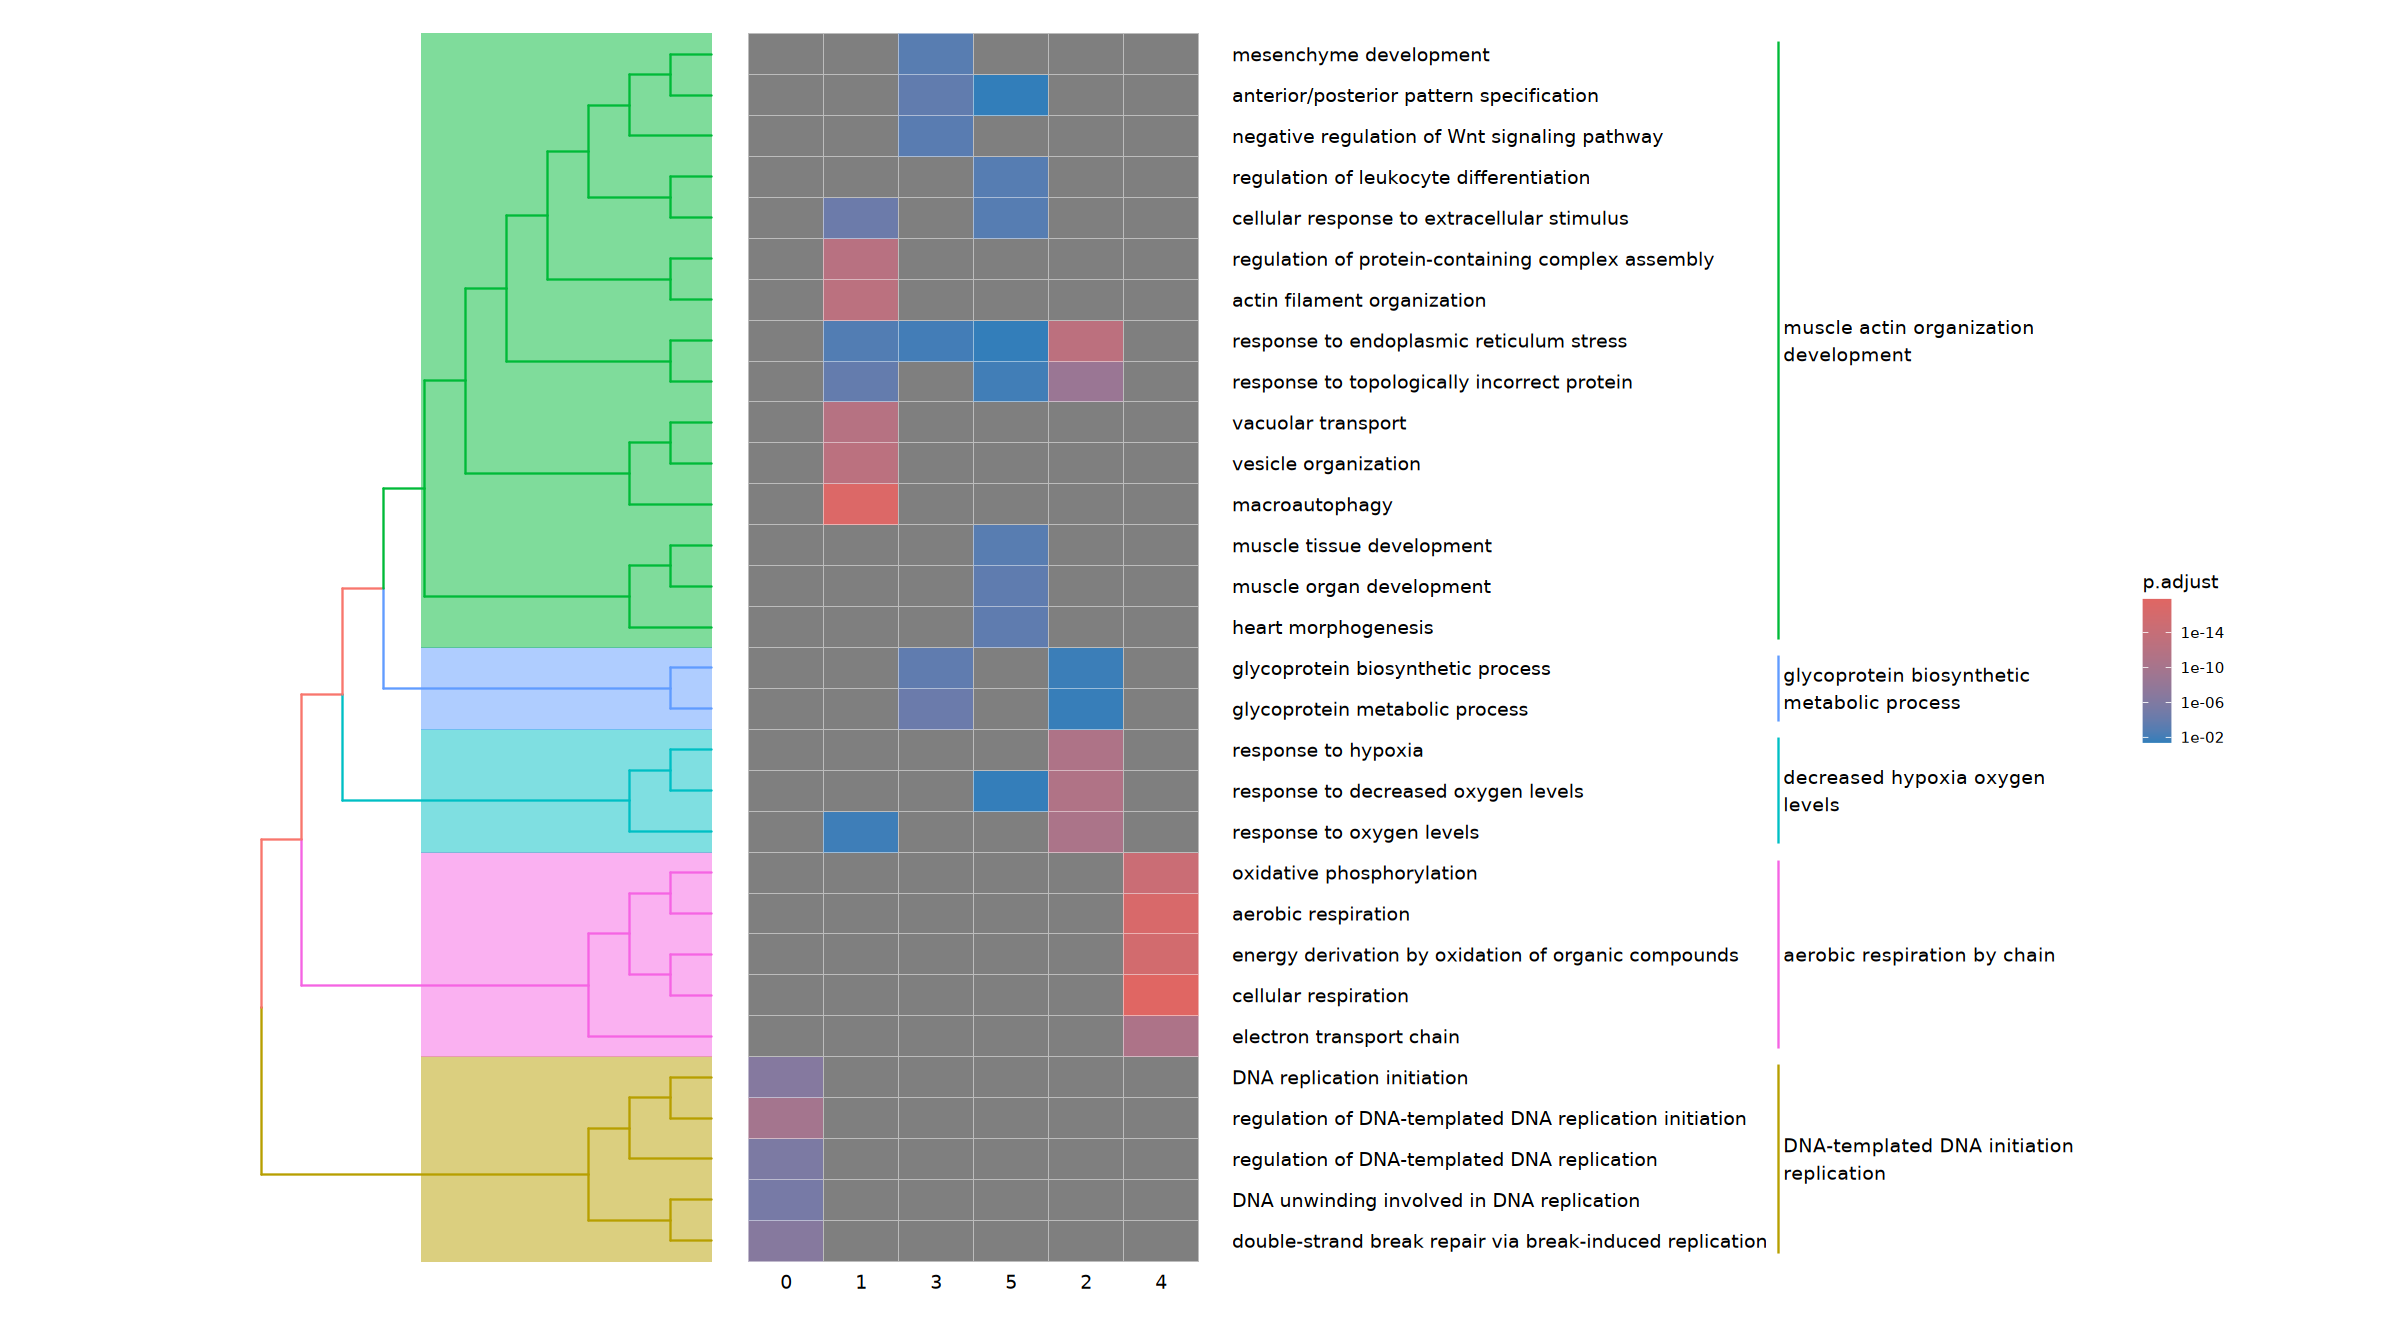

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 11)
suppressMessages({
    suppressWarnings({
        trim_bp <- pairwise_termsim(go_compare_bp, showCategory = 50)
        treeplot(trim_bp, showCategory = 5, label_format_tiplab = 70, offset_tiplab = rel(1.2))
    })
})

### Cellular Component (CC) ontology

In [108]:
# GO enrichment analysis for CC
go_compare_cc <- compareCluster(geneCluster = cluster_gene_list, 
                            fun = "enrichGO", 
                            OrgDb = org.Hs.eg.db, 
                            ont = "CC",  # "BP"、"MF" or "CC"
                            pAdjustMethod = "BH",
                            pvalueCutoff = 0.05,
                            qvalueCutoff = 0.05)

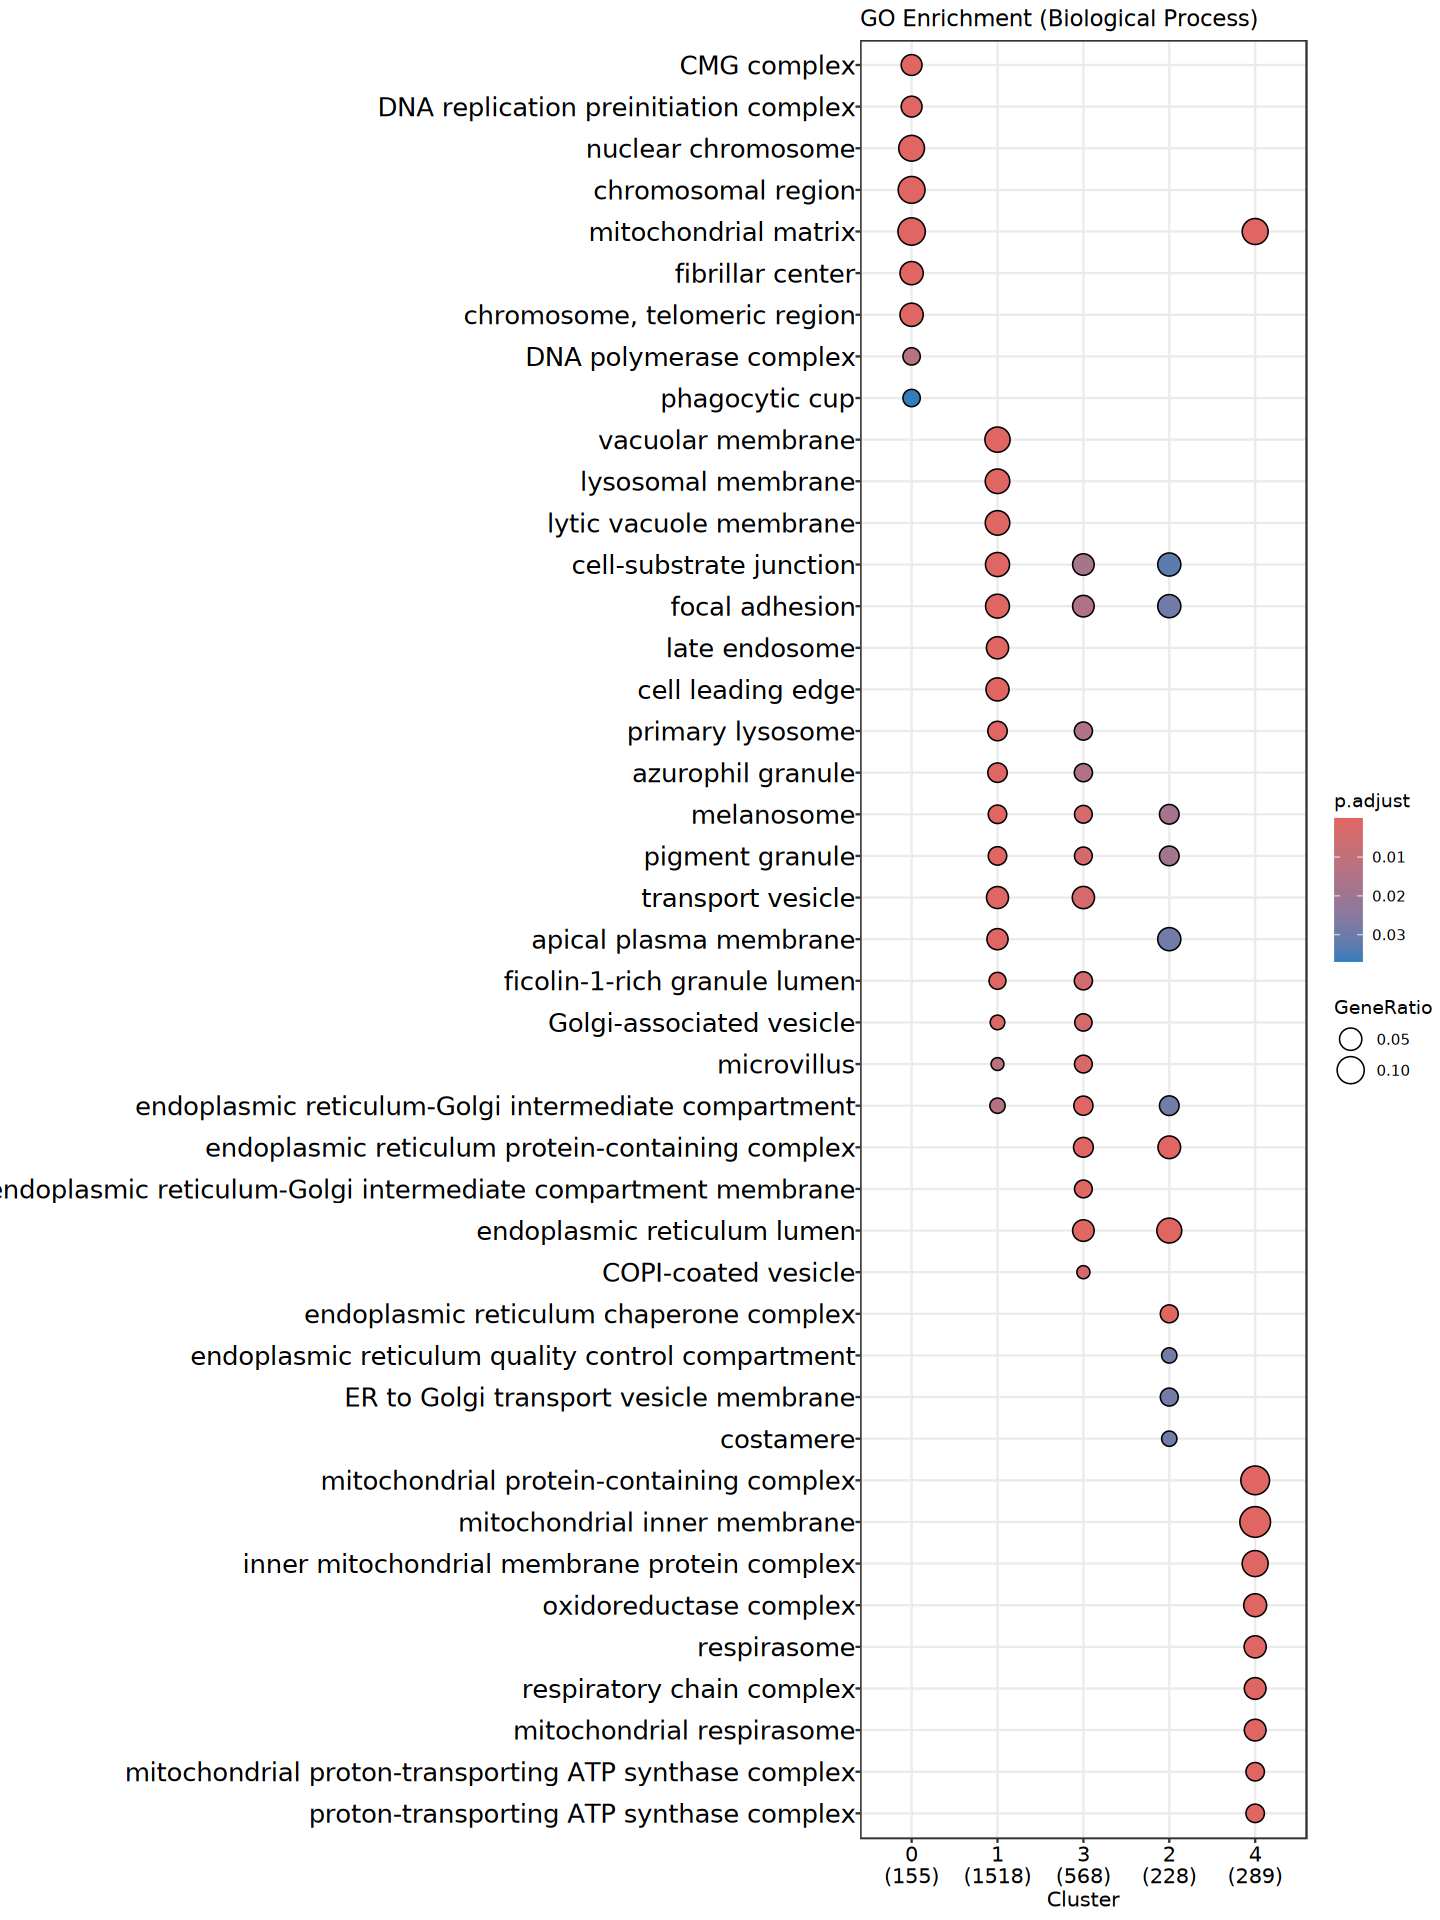

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 16)
cluster.p2 <- dotplot(go_compare_cc, showCategory = 10, label_format = 100,
              title = "GO Enrichment (Cellular Component)")
cluster.p2 + theme(axis.text.y = element_text(size = 15)) +
    theme(axis.text.y = element_text(margin = margin(0, 0, 0, 60)))

Warning message in (function (..., type = getOption("ggplot2.continuous.fill")) :
"log-10 transformation introduced infinite values."


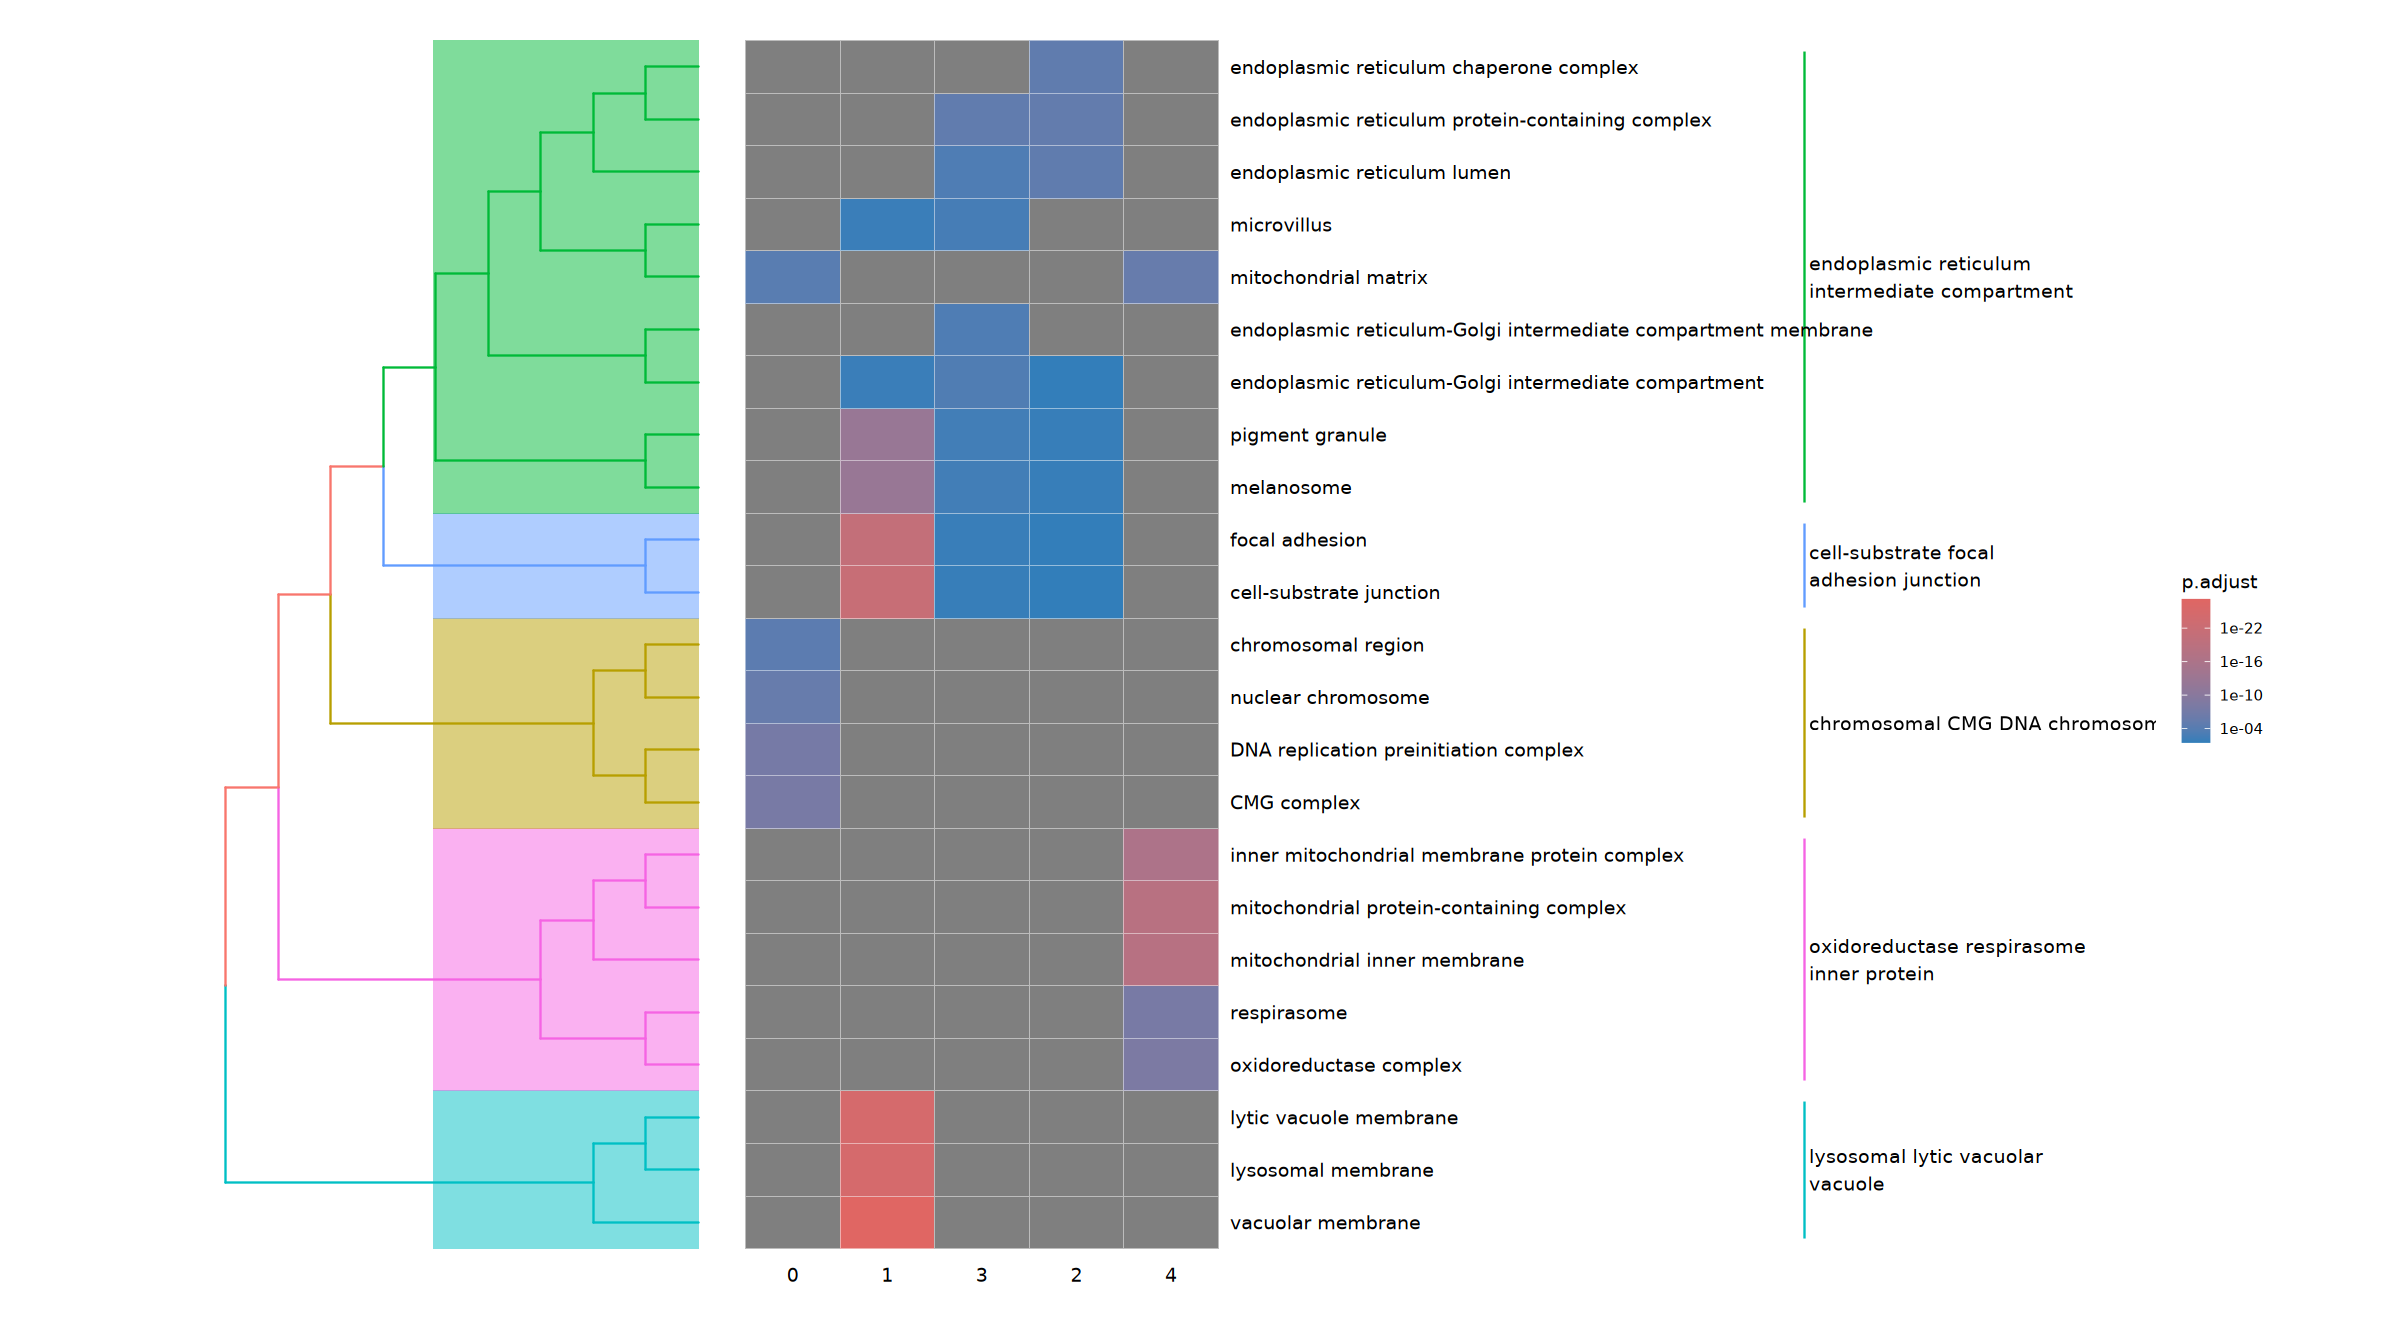

In [123]:
options(repr.plot.width = 20, repr.plot.height = 11)
suppressMessages({
    suppressWarnings({
        trim_bp <- pairwise_termsim(go_compare_cc, showCategory = 50)
        treeplot(trim_bp, showCategory = 5, label_format_tiplab = 70, offset_tiplab = rel(1.4))
    })
})

### Molecular Function (MF) ontology

In [117]:
# GO enrichment analysis for MF
go_compare_mf <- compareCluster(geneCluster = cluster_gene_list, 
                            fun = "enrichGO", 
                            OrgDb = org.Hs.eg.db, 
                            ont = "MF",  # "BP"、"MF" or "CC"
                            pAdjustMethod = "BH",
                            pvalueCutoff = 0.05,
                            qvalueCutoff = 0.05)

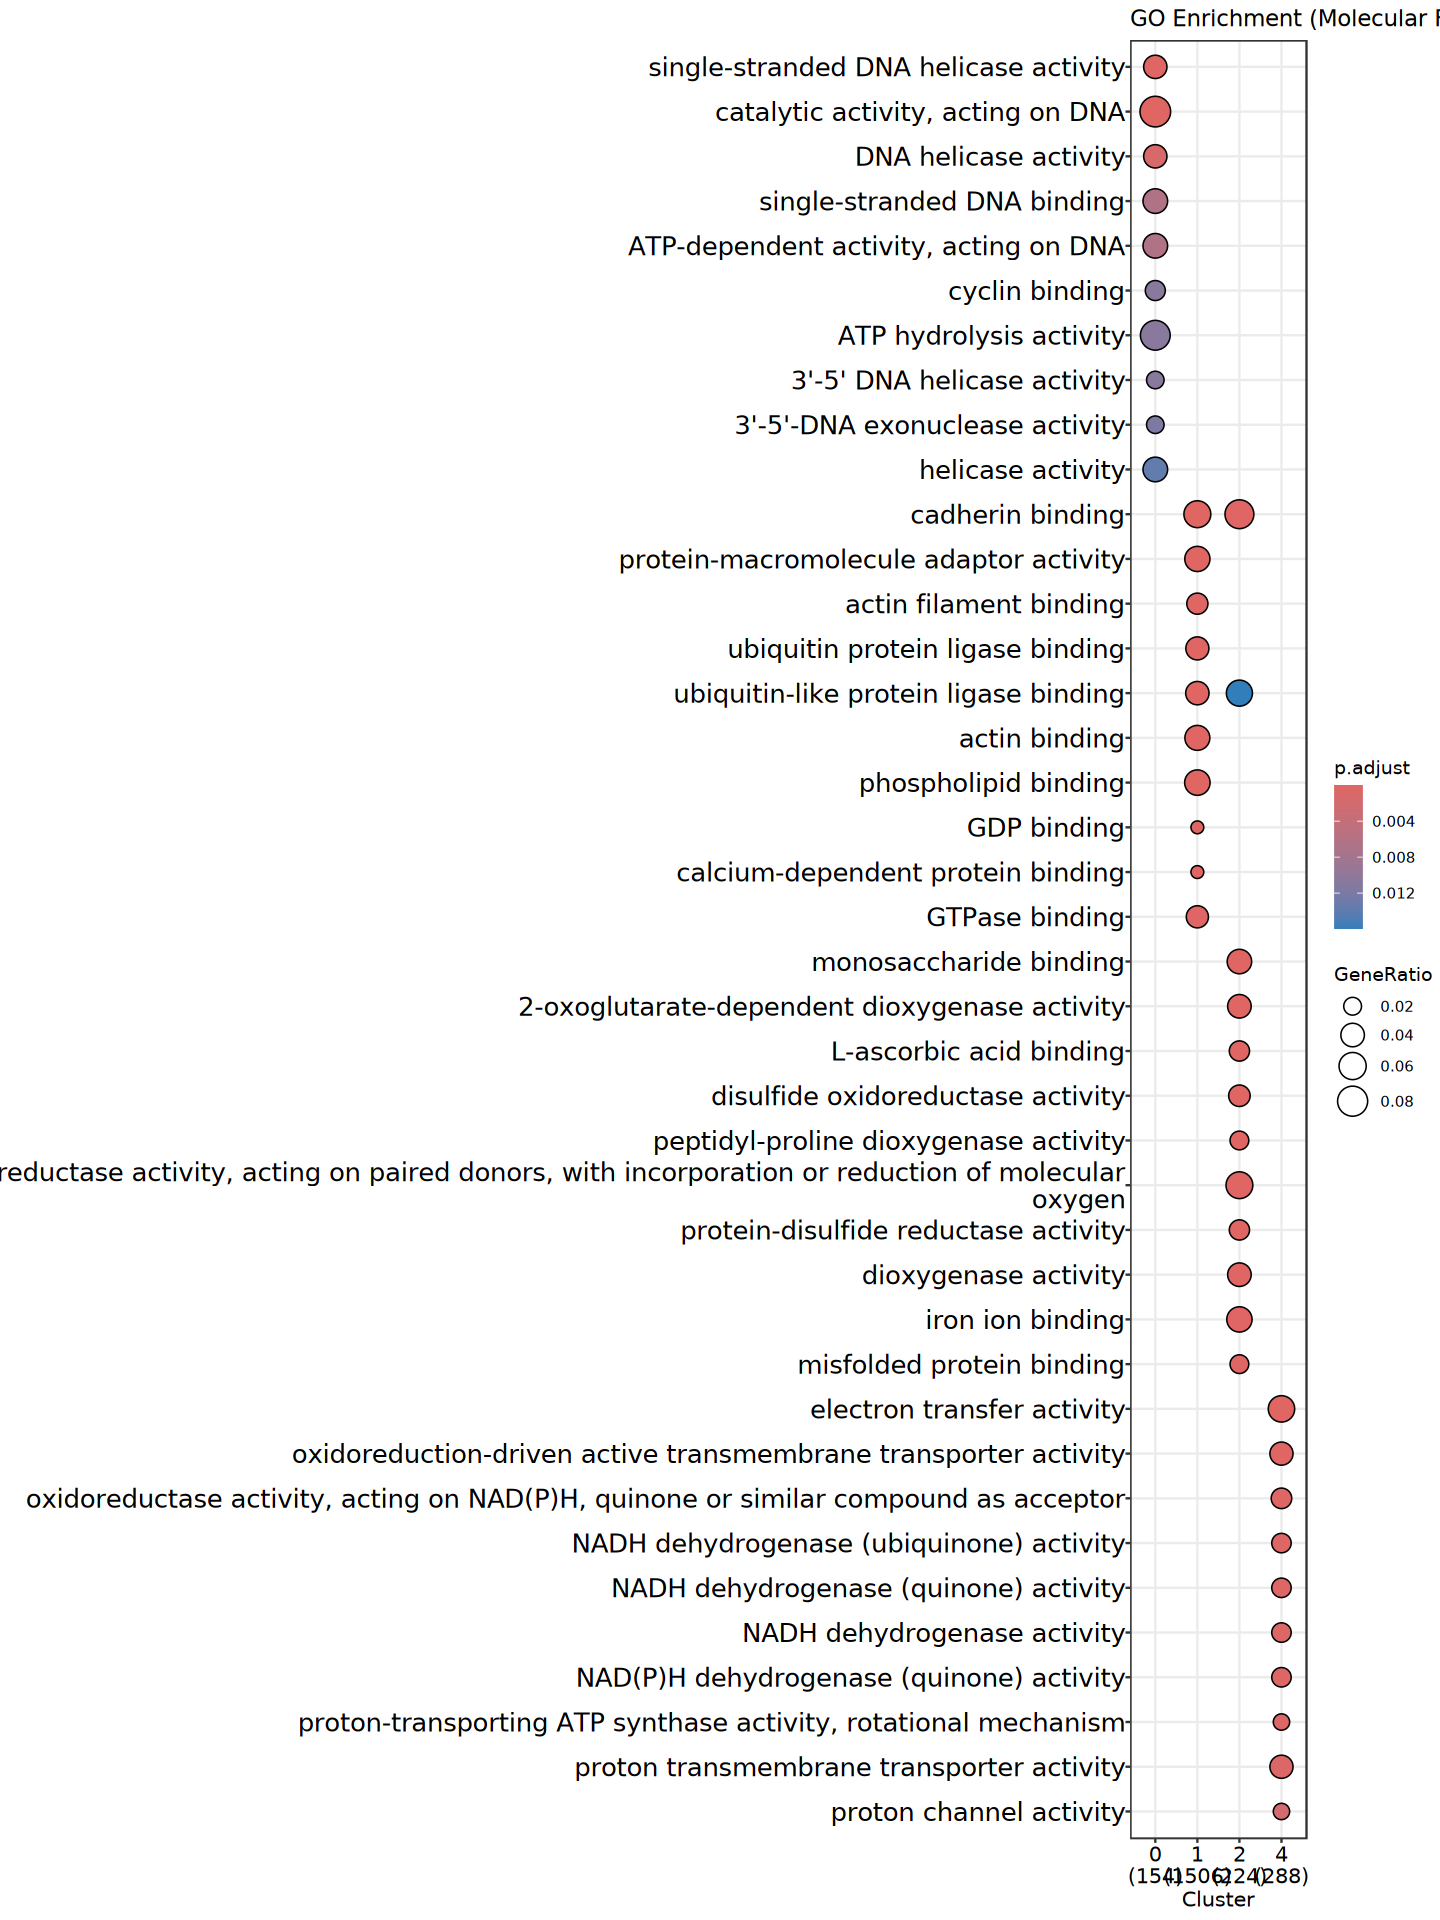

In [118]:
options(repr.plot.width = 12, repr.plot.height = 16)
cluster.p3 <- dotplot(go_compare_mf, showCategory = 10, label_format = 100,
              title = "GO Enrichment (Molecular Function)")
cluster.p3 + theme(axis.text.y = element_text(size = 15)) +
    theme(axis.text.y = element_text(margin = margin(0, 0, 0, 60)))

Warning message in (function (..., type = getOption("ggplot2.continuous.fill")) :
"log-10 transformation introduced infinite values."


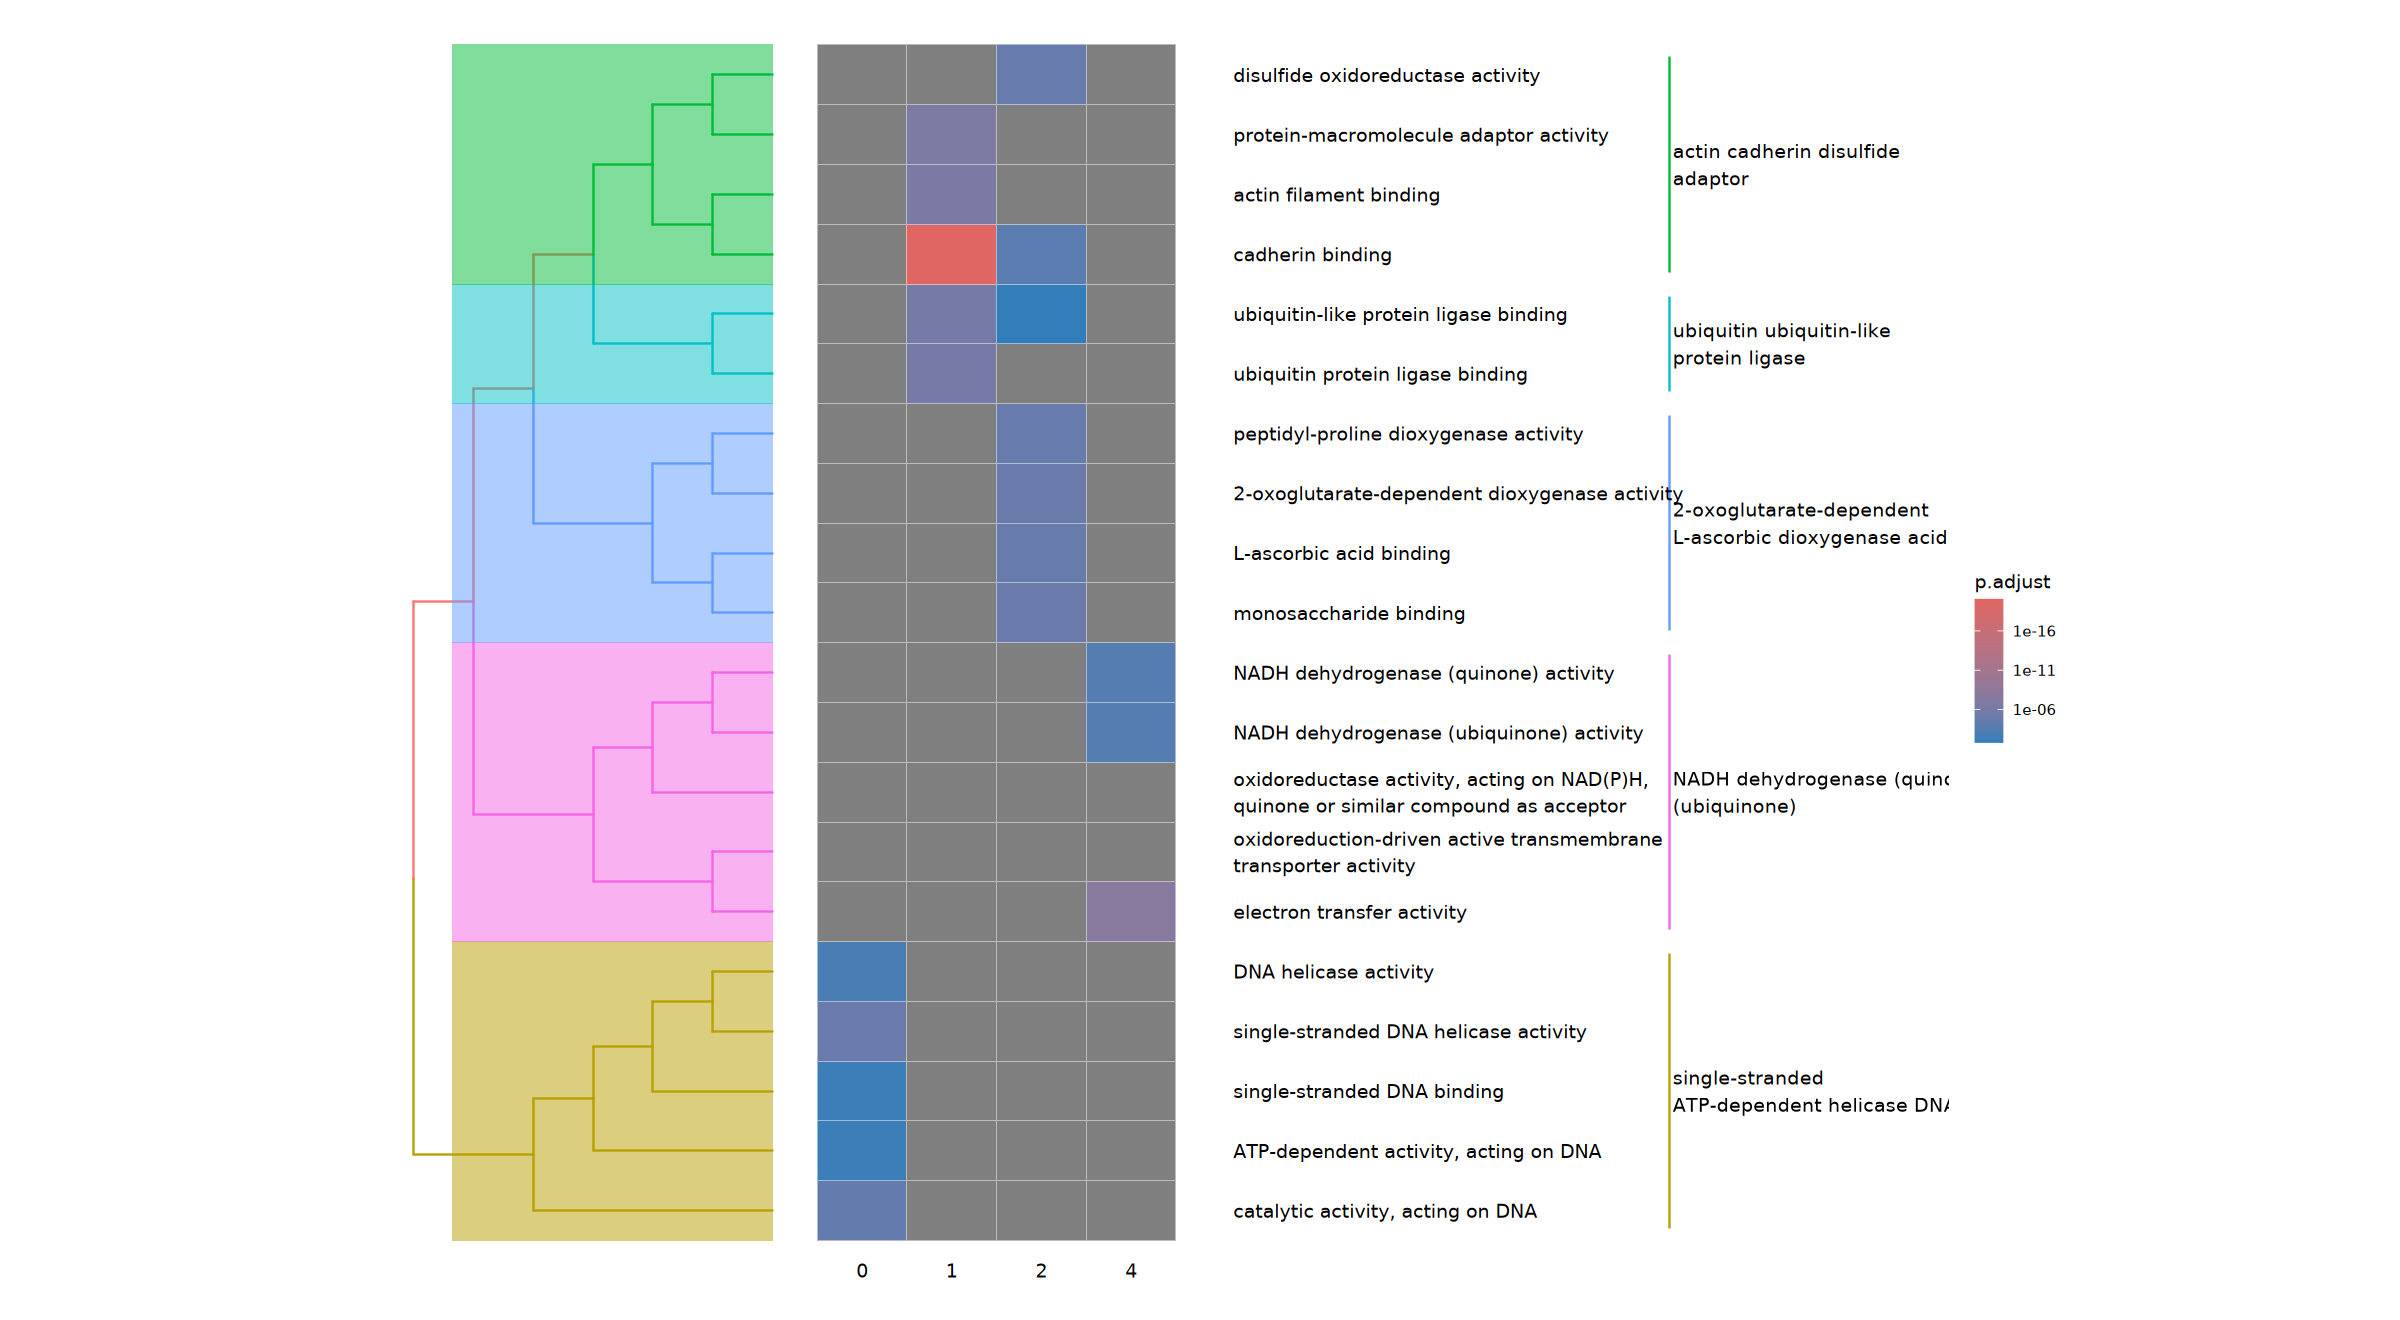

In [129]:
options(repr.plot.width = 20, repr.plot.height = 11)
suppressMessages({
    suppressWarnings({
        trim_bp <- pairwise_termsim(go_compare_mf, showCategory = 50)
        treeplot(trim_bp, showCategory = 5, label_format_tiplab = 50, offset_tiplab = rel(2))
    })
})

## Per cluster analysis

In [192]:
plot_list = list()
for (cluster_nb in sort(names(cluster_gene_list))) {
        cat("_______________________________________________\nCluster: ", cluster_nb, "\n")
        Cluster2.markers <- marker.genes[marker.genes$cluster==cluster_nb 
                                         & marker.genes$p_val_adj < 0.05, ]
        suppressWarnings({Cluster2.gene_ids <- bitr(Cluster2.markers$gene, fromType = "SYMBOL",
                                  toType = "ENTREZID", OrgDb = org.Hs.eg.db)})
        Cluster2.ego <- enrichGO(gene = Cluster2.gene_ids$ENTREZID, 
                                 OrgDb = org.Hs.eg.db, 
                                 ont = "BP", # biological process
                                 pAdjustMethod = "BH", 
                                 pvalueCutoff = 0.05, 
                                 qvalueCutoff = 0.05, 
                                 readable = TRUE)

        # plots
        options(repr.plot.width = 10, repr.plot.height = 7)
        plot_list[[cluster_nb]][[1]] = barplot(Cluster2.ego, showCategory=10) +
                # more space for y labels on the left
                theme(axis.text.y = element_text(margin = margin(0, 0, 0, 50)))

        options(repr.plot.width = 16, repr.plot.height = 10)
        Cluster2.ego <- pairwise_termsim(Cluster2.ego)
        plot_list[[cluster_nb]][[2]] = emapplot(Cluster2.ego, showCategory=20, cex.params = list(category_label = 0.9))

        options(repr.plot.width = 8, repr.plot.height = 8)
        plot_list[[cluster_nb]][[3]] = cnetplot(Cluster2.ego, categorySize="pvalue", 
        foldChange=Cluster2.gene_ids$ENTREZID, showCategory = 3)
}

_______________________________________________
Cluster:  0 


'select()' returned 1:1 mapping between keys and columns

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."


_______________________________________________
Cluster:  1 


'select()' returned 1:1 mapping between keys and columns

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."


_______________________________________________
Cluster:  2 


'select()' returned 1:1 mapping between keys and columns

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."


_______________________________________________
Cluster:  3 


'select()' returned 1:1 mapping between keys and columns

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."


_______________________________________________
Cluster:  4 


'select()' returned 1:1 mapping between keys and columns

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."


_______________________________________________
Cluster:  5 


'select()' returned 1:1 mapping between keys and columns

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."


_______________________________________________
Cluster:  0 


_______________________________________________
Cluster:  1 


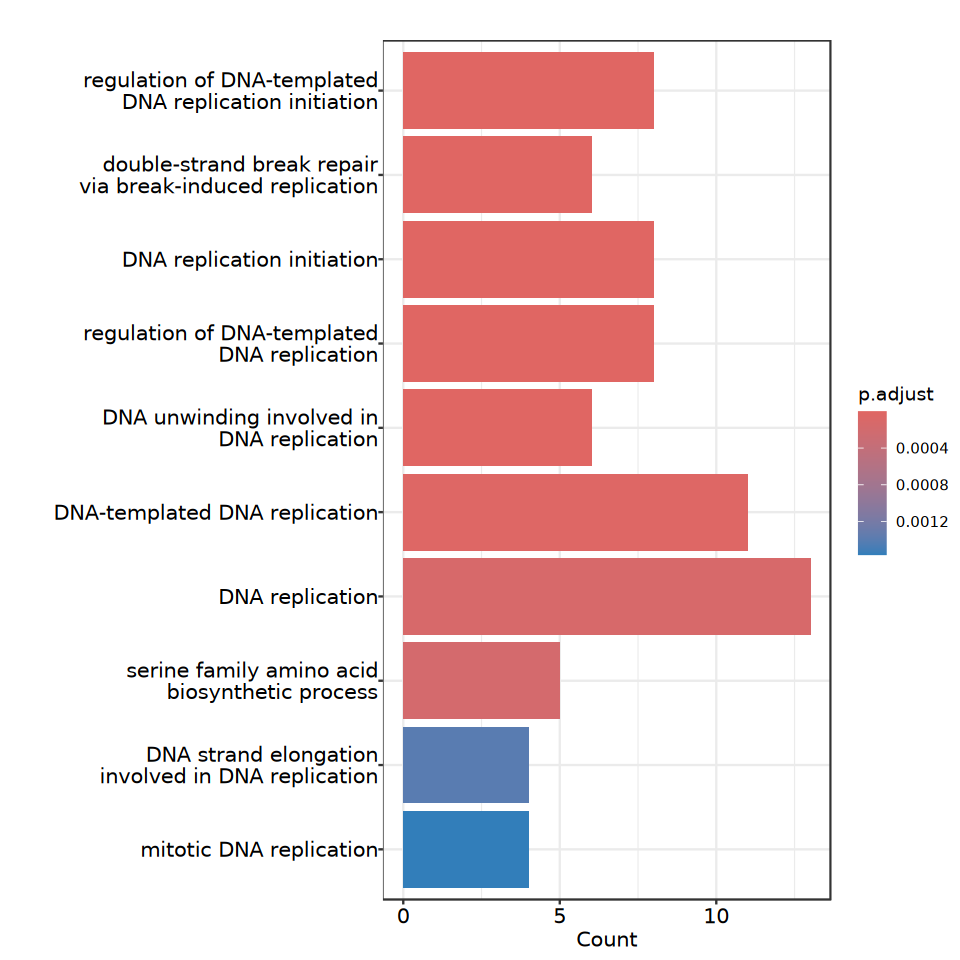

_______________________________________________
Cluster:  2 
_______________________________________________
Cluster:  3 
_______________________________________________
Cluster:  4 
_______________________________________________
Cluster:  5 


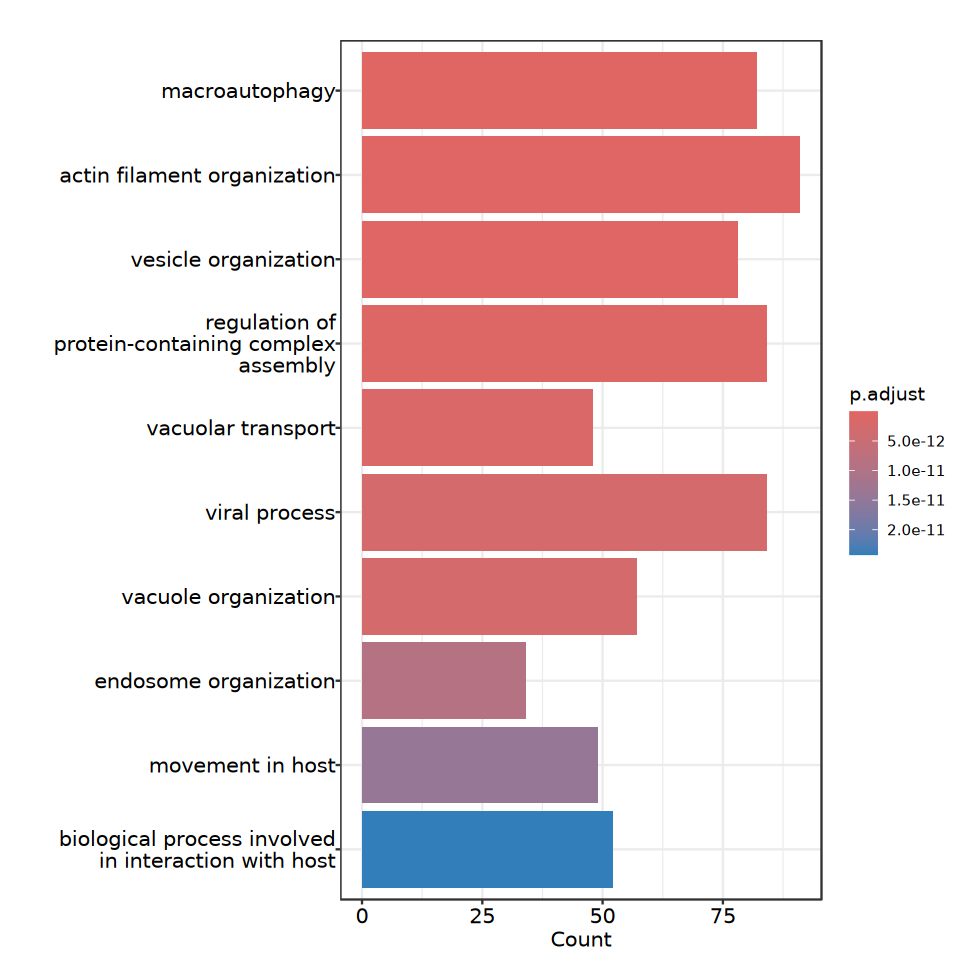

In [193]:
for (cluster_nb in sort(names(cluster_gene_list))) {
    cat("_______________________________________________\nCluster: ", cluster_nb, "\n")
    print(plot_list[[cluster_nb]][[1]])
    # print(plot_list[[cluster_nb]][[2]])
    # print(plot_list[[cluster_nb]][[3]])
}

## Perform gene ontology analysis for one cluster

In [ ]:
Cluster2.markers <- marker.genes[marker.genes$cluster==2 
                                           & marker.genes$p_val_adj < 0.05, ]

In [ ]:
Cluster2.gene_ids <- bitr(Cluster2.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster2.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
"0.45% of input gene IDs are fail to map..."
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster3.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
"2.11% of input gene IDs are fail to map..."


In [ ]:
Cluster2.ego <- enrichGO(gene = Cluster2.gene_ids$ENTREZID, 
                OrgDb = org.Hs.eg.db, 
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)

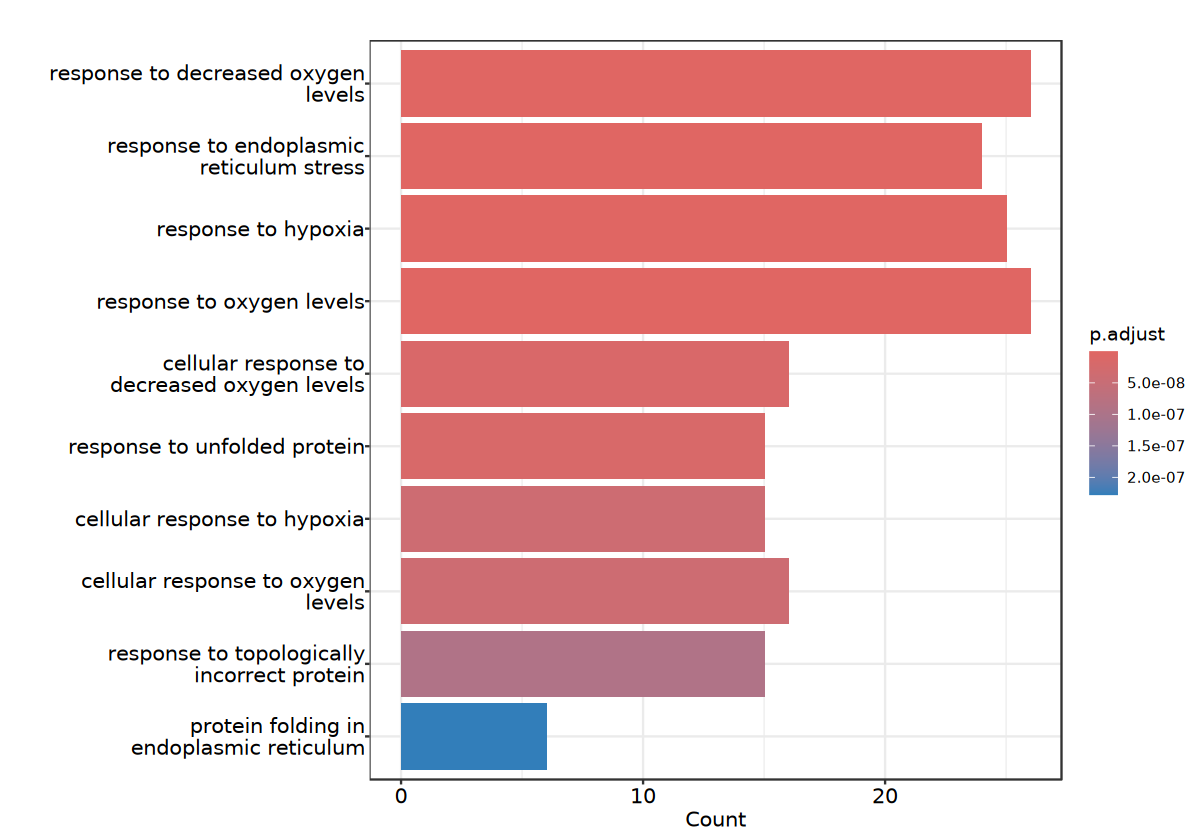

In [164]:
options(repr.plot.width = 10, repr.plot.height = 7)
barplot(Cluster2.ego, showCategory=10) +
        # more space for y labels on the left
        theme(axis.text.y = element_text(margin = margin(0, 0, 0, 50)))

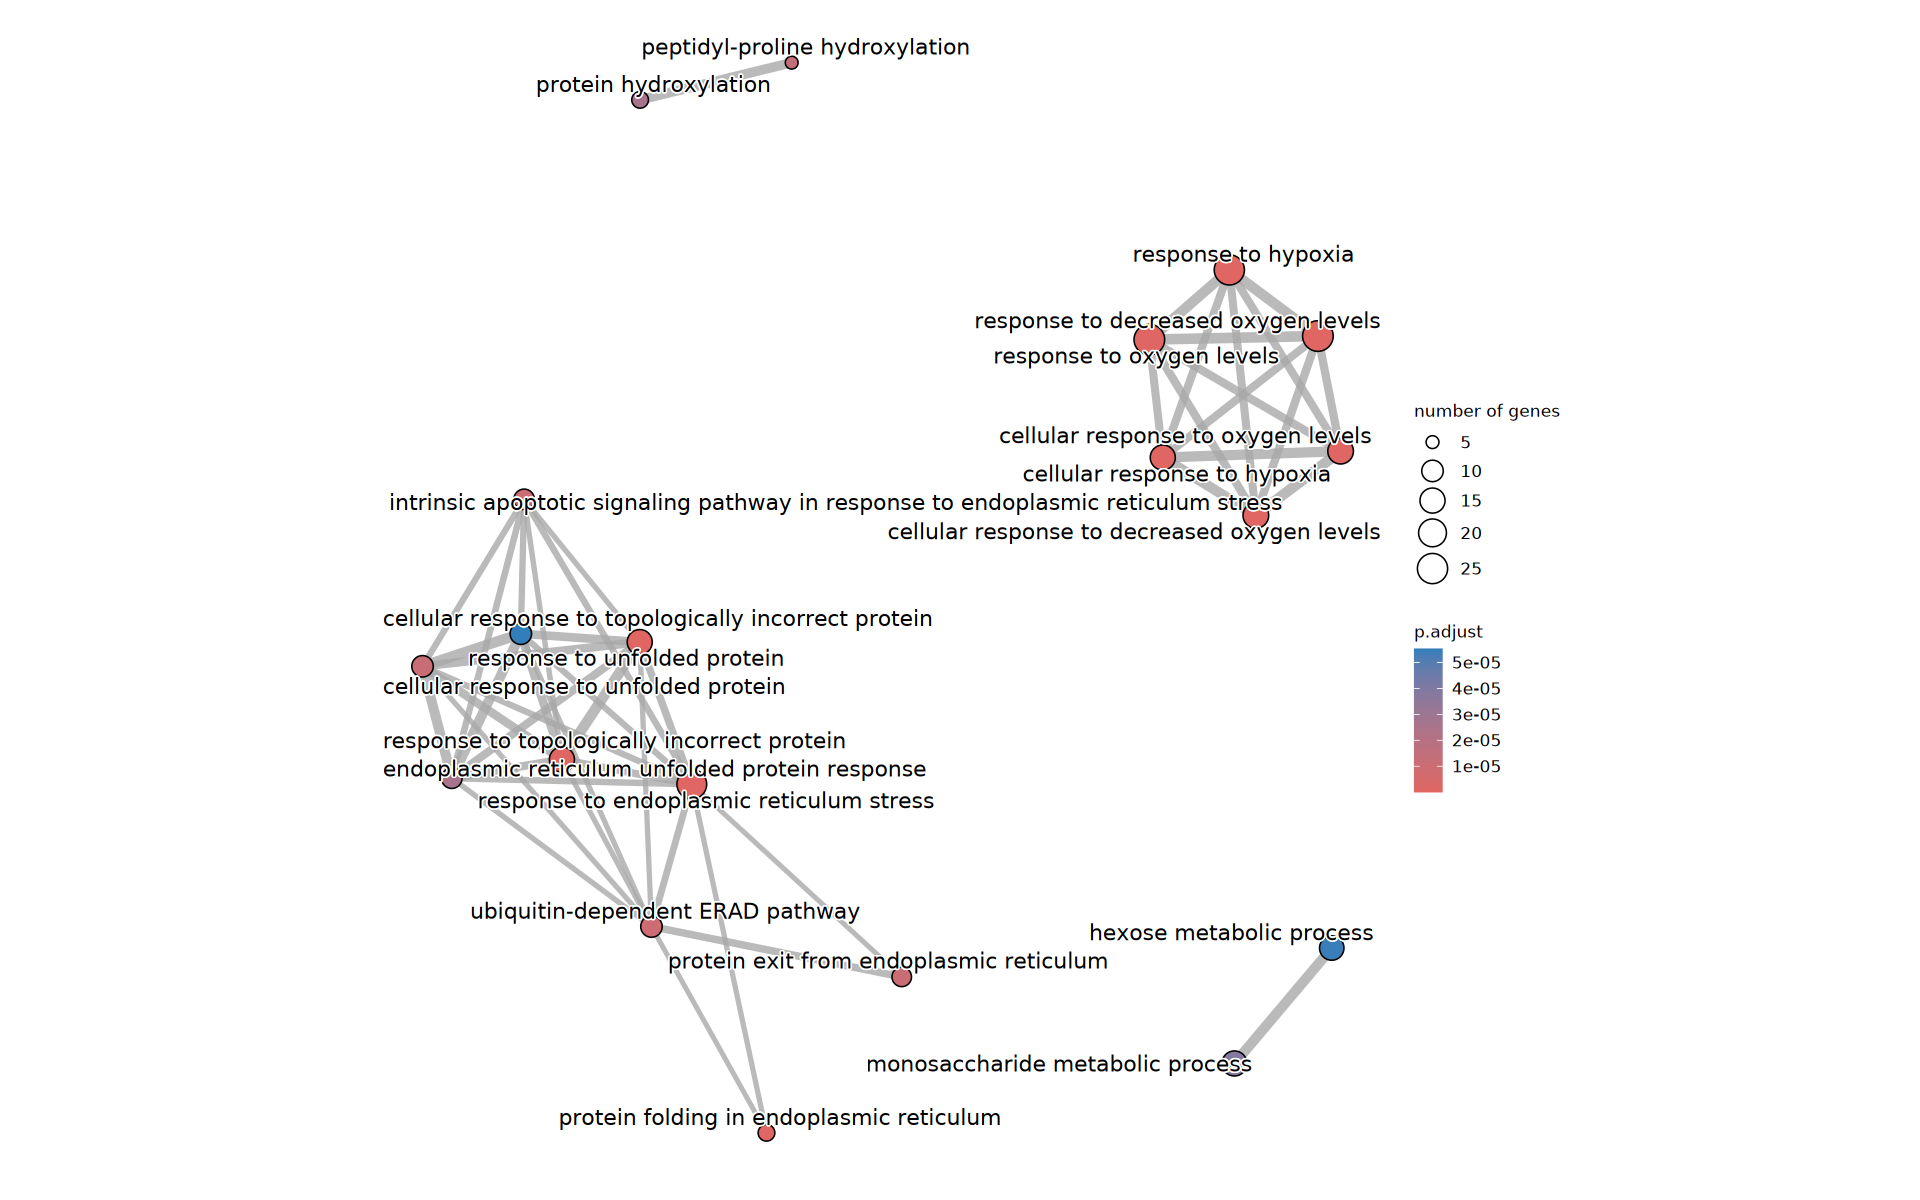

In [160]:
options(repr.plot.width = 16, repr.plot.height = 10)
Cluster2.ego <- pairwise_termsim(Cluster2.ego)
emapplot(Cluster2.ego, showCategory=20, cex.params = list(category_label = 0.9))

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."


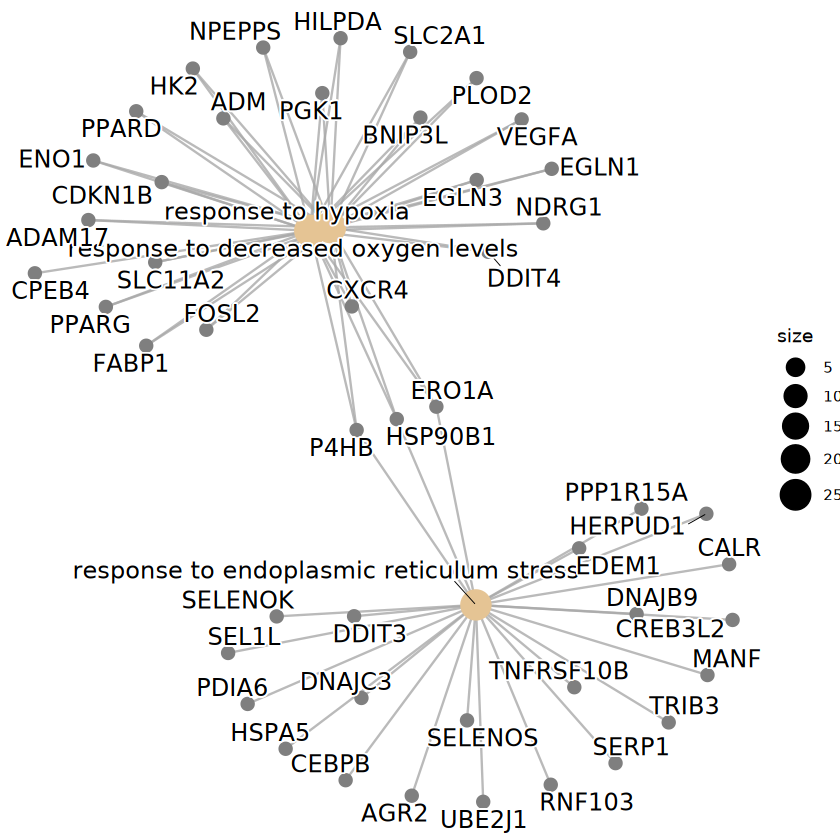

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)
cnetplot(Cluster2.ego, categorySize="pvalue", 
         foldChange=Cluster2.gene_ids$ENTREZID, showCategory = 3)